# Setting up PySpark

In [5]:
import findspark
import os
findspark.init('C:/Users/Onkar/Documents/Spark/spark-2.4.5-bin-hadoop2.7')

In [2]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-9.0.4"

# Connecting to the Google Cloud's MySQL Server

In [10]:
import pymysql
connection = pymysql.connect(host='34.73.158.139',
                             port=int(3306),
                             user='root',
                             password='spark2020!s',
                             db='sentiment')

In [11]:
mycursor = connection.cursor()
mycursor.execute("SELECT * FROM tweets")
myresult = mycursor.fetchall()

# Creating Schema

In [25]:
from pyspark.sql.types import StructType,StructField,StringType,DateType,IntegerType
from pyspark import SparkContext
import pyspark.sql 

In [17]:
spark = SparkSession.builder.getOrCreate()

In [44]:
# Define schema
schema = StructType([
    StructField("id", StringType(), True),
    StructField("permalink", StringType(), True),
    StructField("username", StringType(), True),
    StructField("tweet_text", StringType(), True),
    StructField("date", DateType(), True),
    StructField("retweets", IntegerType(), True), 
    StructField("favorites", IntegerType(), True), 
    StructField("tv_series", StringType(), True), 
    StructField("sentiment", IntegerType(), True), 
    StructField("season", IntegerType(), True) 
])

In [45]:
df = spark.createDataFrame(myresult, schema)

# Basic Analysis

SparkSQL and DataFrames are used to do data analysis.  <Br>
    
Some basic metrics:
- Total Tweets
- Total Days
- Total Users 

Advanced metrics: 
These metrics are used to asses popularity of the show 

- Tweets per day, series
- Average favorites 
- Average Retweets 
    
Furthermore, we check which is the most retweeted tweet and most liked tweets for each show

## SparkSql

Create a temporary table 

In [242]:
spark.sql("Drop table if exists temp")

DataFrame[]

In [243]:
df.createTempView("temp")

In [244]:
spark.catalog.listTables()

[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

### Show records

In [50]:
spark.sql("Select * from temp limit 5").show()

+----------+--------------------+---------------+--------------------+----------+--------+---------+-----------+---------+------+
|        id|           permalink|       username|          tweet_text|      date|retweets|favorites|  tv_series|sentiment|season|
+----------+--------------------+---------------+--------------------+----------+--------+---------+-----------+---------+------+
|2147483647|https://twitter.com/|     desstiny31|money heist was r...|2020-04-04|       0|        0|Money Heist|        1|     4|
|2147483647|https://twitter.com/|northsidemozart|Yh so far money h...|2020-04-04|       0|        1|Money Heist|        1|     4|
|2147483647|https://twitter.com/|     simshadyyy|dudeeee money hei...|2020-04-04|       0|        0|Money Heist|        1|     4|
|2147483647|https://twitter.com/|   barbiana____|i’m only on seaso...|2020-04-04|       0|        0|Money Heist|        1|     4|
|2147483647|https://twitter.com/|   ThatGuyNath_|I’m bored of ever...|2020-04-04|       0|

### Total Tweets

In [247]:
spark.sql("Select count(*) from temp").show()

+--------+
|count(1)|
+--------+
|   14000|
+--------+



There are 140,000 Tweets 

### Total Days 

In [248]:
spark.sql("Select count(distinct date) from temp").show()

+--------------------+
|count(DISTINCT date)|
+--------------------+
|                   7|
+--------------------+



We have 7 days of data 

### Total Users

In [249]:
spark.sql("Select count(distinct username) from temp").show()

+------------------------+
|count(DISTINCT username)|
+------------------------+
|                   13018|
+------------------------+



13,018 Users have tweeted 

## DataFrame

### Most liked tweets

In [251]:
most_liked = df.groupby("tv_series").agg({"favorites":"max"}).collect()

In [252]:
Most_liked_MH = df.select("tweet_text").filter(df.tv_series == "Money Heist").filter(df.favorites == most_liked[0][1]).collect()

In [253]:
Most_liked_MH[0][0]

'Okay guys Let’s settle this once and for all. Retweet For Game of Thrones Like f'

In [254]:
Most_liked_TG = df.select("tweet_text").filter(df.tv_series == "Tiger King").filter(df.favorites == most_liked[1][1]).collect()

In [255]:
Most_liked_TG[0][0]

'This Tiger King show y’all was hyping up.... it’s giving me hillbilly honey boo '

### Most Retweeted tweets

In [86]:
most_retweeted = df.groupby("tv_series").agg({"retweets":"max"}).collect()

In [87]:
Most_retweeted_MH = df.select("tweet_text").filter(df.tv_series == "Money Heist").filter(df.retweets == most_retweeted[0][1]).collect()

In [89]:
Most_retweeted_MH[0][0]

'I want this bitch dead in the very first episode of Season 4 !!!!!! #MoneyHeist4'

In [94]:
Most_retweeted_TG = df.select("tweet_text").filter(df.tv_series == "Tiger King").filter(df.retweets == most_retweeted[1][1]).collect()

In [95]:
Most_retweeted_TG[0][0]

'This Tiger King show y’all was hyping up.... it’s giving me hillbilly honey boo '

### Tweets per day by series

In [257]:
df.groupby('tv_series', 'date').agg({'id': 'count'}).show()

+-----------+----------+---------+
|  tv_series|      date|count(id)|
+-----------+----------+---------+
| Tiger King|2020-04-02|     1000|
| Tiger King|2020-03-31|     1000|
| Tiger King|2020-04-01|     1000|
|Money Heist|2020-04-02|     1000|
|Money Heist|2020-03-31|     1000|
|Money Heist|2020-04-03|     1000|
| Tiger King|2020-04-03|     1000|
| Tiger King|2020-03-30|     1000|
|Money Heist|2020-03-29|     1000|
|Money Heist|2020-03-30|     1000|
| Tiger King|2020-04-04|     1000|
| Tiger King|2020-03-29|     1000|
|Money Heist|2020-04-01|     1000|
|Money Heist|2020-04-04|     1000|
+-----------+----------+---------+



We have exactly 1000 tweets per day for each show

### Average likes and retweets 

In [97]:
df.groupby('tv_series').agg({'retweets': 'average','favorites':'average'}).show()

+-----------+-----------------+------------------+
|  tv_series|   avg(favorites)|     avg(retweets)|
+-----------+-----------------+------------------+
|Money Heist|4.318142857142857|0.7142857142857143|
| Tiger King|7.783571428571428|0.8718571428571429|
+-----------+-----------------+------------------+



We observer Tiger King's tweets are more popular on both metrics

# Advanced Analysis

Task:
- Visualizing data
- Data cleaning
- Sentiment Analysis using TextBlob

In [145]:
import numpy as np
import pandas as pd
import nltk 
from nltk.corpus import movie_reviews
from nltk import WordNetLemmatizer
from nltk import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
from textblob import TextBlob
from matplotlib import pyplot as plt

In [98]:
tweets_df = df.toPandas()

In [111]:
tweets_df.head()

,id,permalink,username,tweet_text,date,retweets,favorites,tv_series,sentiment,season
0,2147483647,https://twitter.com/,desstiny31,money heist was rlly fucking w me I love her,2020-04-04,0,0,Money Heist,1,4
1,2147483647,https://twitter.com/,northsidemozart,Yh so far money heist is coldddd,2020-04-04,0,1,Money Heist,1,4
2,2147483647,https://twitter.com/,simshadyyy,dudeeee money heist is so GOOOODDD whoa.,2020-04-04,0,0,Money Heist,1,4
3,2147483647,https://twitter.com/,barbiana____,i’m only on season 1 but money heist good AF,2020-04-04,0,0,Money Heist,1,4
4,2147483647,https://twitter.com/,ThatGuyNath_,I’m bored of everything rn fackkk don’t wanna ...,2020-04-04,0,0,Money Heist,1,4


## Distribution of tweet size

Characters' distribution 

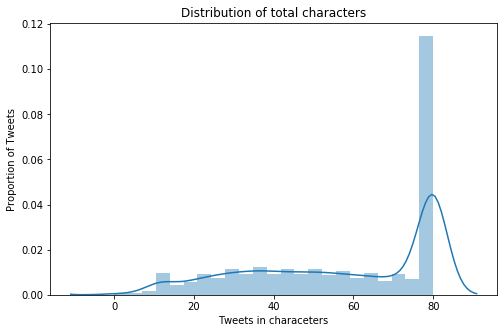

In [128]:
plt.figure(figsize  = (8,5))
ax = sns.distplot(tweets_df["tweet_text"].apply(len))
ax.set_title("Distribution of total characters")
ax.set_xlabel("Tweets in characeters")
ax.set_ylabel("Proportion of Tweets");

Tokens distribution 

In [123]:
tokens = tweets_df["tweet_text"].apply(nltk.word_tokenize)

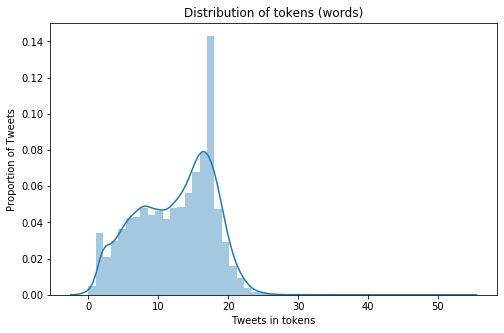

In [130]:
plt.figure(figsize  = (8,5))
ax = sns.distplot(tokens.apply(len))
ax.set_title("Distribution of tokens (words)")
ax.set_xlabel("Tweets in tokens")
ax.set_ylabel("Proportion of Tweets");

## Cleaning the Tweets

In [143]:
tokens_clean = tokens.apply(lambda tweet: [t for t in tweet if ((t not in stopwords.words("english")) and (t.isalpha() and len(t)>2))]) 

In [153]:
tweets_df["tweet_clean"] = tokens_clean.apply(" ".join)

## Sentiment Analysis using TextBlob

In [167]:
tweets_df["polarity"] = tweets_df["tweet_clean"].apply(lambda tweet:TextBlob(tweet).sentiment.polarity)

### Example of postive tweets 

In [178]:
Positive_tweets = list(tweets_df.loc[tweets_df["polarity"] > 0.8, "tweet_text"])

In [200]:
Positive_tweets[0:10]

['This season of money heist was the best one by farrrrrr',
 '#MoneyHeist is probably the best series to come to Netflix, ever. #LeCasaDePapel',
 'Money Heist is the best show on Netflix don’t @me.',
 'Money Heist is the best show on Netflix. fight me',
 '#MoneyHeistPart4 is freaking awesome.... you did a great job #netflix #moneyheis',
 'money heist is the best show to ever exist',
 'Money heist is actually incredible.',
 'Ay Money Heist this season is hotter than me on my best day',
 'money heist is the best thing on netflix ',
 'money heist best series made hands down ']

These Tweets are indeed very positive 

### Example of negative tweets

In [183]:
Negative_tweets = list(tweets_df.loc[tweets_df["polarity"] < -0.8, "tweet_text"])

In [199]:
Negative_tweets[0:10]

['Money Heist is sly boring to me ',
 'Money heist season 4 episode 1 is insane',
 'Nvm, this is god awful boring. I’m bout to start Money Heist',
 '#MoneyHeist is boring. There i said it. I said what everyone is thinking #MoneyH',
 'this season of money heist was so boring omg',
 'Very annoying... How would I watch money heist like this',
 'If you find money heist boring then you need to check your temperature',
 "Money Heist was terrible, like I just don't get the hype.. will continue BrBa fo",
 'I WATCHED MONEY HEIST AND I FUCKING HATE IT you pathetic burgers just to get in ',
 'So Today I downloaded money heist season 1, 2 and 3 Cox Twitter is boring, I jus']

Some people find the Money Heist show boring

### Overall sentiment of both shows

In [220]:
def set_sentiment(x):
    if x > 0:
        return "positive"
    elif x < 0:
        return "negative"
    else:
        return "neutral"

In [221]:
tweets_df["sentiment"] = tweets_df["polarity"].apply(set_sentiment)

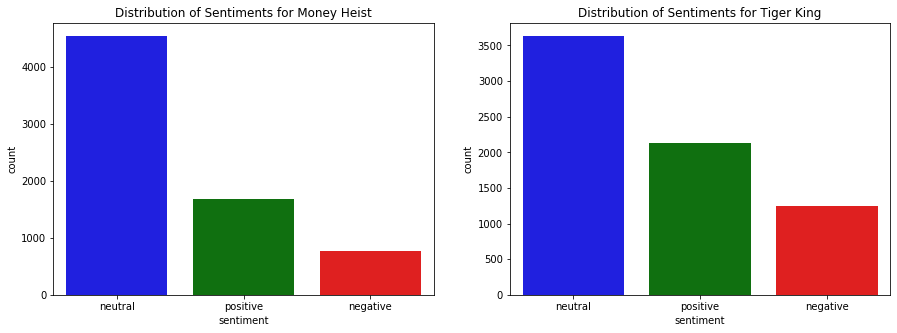

In [239]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.countplot(tweets_df.loc[tweets_df["tv_series"]=="Money Heist", "sentiment"], ax = ax[0],  palette=["blue", "green", "red"], order = tweets_df["sentiment"].value_counts().index)
ax[0].set_title("Distribution of Sentiments for Money Heist")
sns.countplot(tweets_df.loc[tweets_df["tv_series"]=="Tiger King", "sentiment"], ax = ax[1], palette=["blue", "green", "red"],  order = tweets_df["sentiment"].value_counts().index)
ax[1].set_title("Distribution of Sentiments for Tiger King");

- Most tweets on both the series seems neutral
- More positive sentiments than negative for both the shows 

# Future Scope

- More advanced pre-processing techniques  
- Modeling the sentiments using word embedding approach
- Acquiring more data for better analysis